In [1]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    notebook=1
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    notebook=0
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload
if notebook:
    import winsound
import dill
import datetime as dt
import plotly

Notebook
GPU detected


In [2]:
#everything here could be JSON

################################################
# Setup Deafult Variables                       # 
################################################
learning_rate = 2.5e-4
warm_up       = 4
batch_size    = 512
epochs        = 100
n_data       = 5e5
scenario    = "stop_muon"
patience = 5

################################################
# Setup Model hyperparameters                  # 
################################################

# make in model

################################################
# Setup Other Hyperparameters                   # 
################################################


loss_method   = "von Mises"
n_neighbors   = 6 # SKRIV SELV IND
wandblog      = 0
opt = Adam(learning_rate)

if wandblog:
    import wandb
    !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf
    #checks
    wandb.init(project="icecube", group=scenario,entity="chri862z")

    # Declare for log
    wandb.config.angleunit=angleunit
    wandb.config.hidden_states = hidden_states
    wandb.config.n_data = n_data
    wandb.config.forward = forward
    wandb.config.dropout = dropout
    wandb.config.learning_rate = learning_rate
    wandb.config.warm_up = warm_up
    wandb.config.batch_size = batch_size
    wandb.config.loss_func = loss_method
    wandb.config.n_neighbors = n_neighbors
    wandb.config.optimizer = 'Adam'
    wandb.run.name = wandb.run.id
    wandbname=wandb.run.id

In [3]:
################################################
# Load data                      # 
################################################

import dev.data_load as dl
reload(dl)
graph_data=dl.graph_data
dataset=graph_data(n_data=n_data, n_neighbors=n_neighbors, restart=0)
idx_lists = dataset.index_lists
# Split data
dataset_train = dataset[idx_lists[0]]
dataset_val   = dataset[idx_lists[1]]
dataset_test  = dataset[idx_lists[2]]
loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size) # the different loaders work very very differently, beware
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
if notebook:
    winsound.Beep(400,300)

Not notebook
Not notebook
Connecting to db-file
Loading Muons
Reading files


C:\Users\chris\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\chris\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Splitting data to events
[ 45  56 323 ...  52  47  30]


  0%|                                                                                       | 0/500000 [00:00<?, ?it/s]

     dom_x    dom_y    dom_z      time  charge_log10  SRTInIcePulses
0 -0.25614 -0.52108  0.29178 -0.902557     -0.088028               0
1  0.50527  0.25788 -0.20864 -1.099296      0.378965               0
2 -0.06670  0.27692  0.00422  0.424602      0.791982               0
3  0.30341  0.33564  0.03637 -0.125602      1.160970               0
4  0.30341  0.33564  0.03637 -0.114116     -1.656923               0
   stopped_muon
0             1
1             1
2             0
3             1
4             0
Generating adjacency matrices


100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [05:49<00:00, 1431.41it/s]


Saving dataset
Loading data to memory


In [4]:
import dev.stopGCN as m
reload(m)
# model=m.GCN0(6)
model=m.stopGCN(n_out=1)

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
def metrics(y_reco, y_true):
    FPR, TPR, _ = roc_curve(y_true, y_reco)
    AUC=roc_auc_score(y_true, y_reco)
    return FPR, TPR, AUC


In [6]:
def plot_roc(loader, save=False, save_path=''):
    '''Function to test and plot performance of Graph DL
    input should be dom pos x,y,z , time, charge(log10)
    target should be energy(log10),zenith angle, azimuthal angle, NOT unit vec 
    '''
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()
    FPR, TPR, AUC = metrics(y_reco, y_true)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
    ax[0].plot(FPR, TPR, label=f'ROC with AUC: {AUC}')
    ax[1].hist(y_reco, histtype='step', bins=100)
    if save:
        plt.savefig(save_path)

In [7]:
# ################################################
# # Setup functions                            # 
# ################################################
from tensorflow_addons.losses import SigmoidFocalCrossEntropy as loss_func
loss_func=loss_func()
# import tensorflow.keras.losses as bc

# loss_func=bc.BinaryCrossentropy(from_logits=False, label_smoothing=0, reduction=tf.keras.losses.Reduction.NONE)

def lr_schedule(epochs = epochs, initial = learning_rate, warm_up=warm_up, decay = 0.9):
    n = 1
    lr = initial
    yield lr
    while n < warm_up:
        lr *= 2
        n  += 1
        yield lr
    while True:
        lr *= decay
        n  += 1 
        yield lr


#make functions into tf functions

@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training = True)
        targets     = tf.cast(targets, tf.float32)
        loss        = loss_func(targets, predictions)
        loss = tf.reduce_mean(loss)
        loss       += sum(model.losses)

    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 
    
    loss       = loss_func(targets, predictions)
    out = tf.reduce_mean(loss)

    return predictions, targets, out


def validation(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)
    
    y_reco  = tf.concat(prediction_list, axis = 0)
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32)
    
    _,_, auc= metrics(y_reco, y_true)
    
    return loss, auc

In [8]:
k=0
if notebook:
    k=0.2
tot_time=0
current_batch = 0
current_epoch = 1
loss          = 0
lowest_loss   = np.inf
early_stop    = 1
early_stop_counter    = 0
if notebook:
    pbar0          = tqdm(total = epochs, position = 0, leave = True)
    pbar0.set_description(f"Epochbar")
pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)
start_time    = time.time()
lr_gen        = lr_schedule(initial=learning_rate)
learning_Rate = next(lr_gen)
cwd = osp.abspath('')
save_path = osp.join(cwd, 'trained_models/'+scenario)
if not osp.isdir(save_path):
    os.makedirs(save_path)
    print('New folder for saving '+scenario+' made')
# Implement saving model archictecture to wandb
if wandblog:
    save_path = osp.join(save_path, wandbname)
if not osp.isdir(save_path):
    os.makedirs(save_path)
    print('New folder for saving run '+wandbname)
summarylist=[]
for batch in loader_train:
    inputs, targets = batch
    out             = train_step(inputs, targets)
    loss           += out
    if current_epoch==1 and current_batch==0:
        model.summary()
        if wandblog:
            summary=model.summary(print_fn=summarylist.append)
            table=wandb.Table(columns=["Layers"])
            for s in summarylist:
                table.add_data(s)
            wandb.log({'Model summary': table})
            n_params=np.sum([np.prod(v.get_shape()) for v in model.variables])
            wandb.config['n_params']=n_params
    current_batch  += 1
    pbar.update(1)
    pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
    
    
    if current_batch == loader_train.steps_per_epoch:
        t=time.time() - start_time
        tot_time+=t
        print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
        print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

        loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
        val_loss, auc = validation(loader_val)
#         val_loss, val_metric = validation(loader_val)
        if wandblog:
            wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
                       "Val loss": val_loss,
                      'AUC': auc})
        print(f"Avg loss of validation: {val_loss:.6f}")
        print(f"AUC: {auc}")
        if val_loss < lowest_loss:
            early_stop_counter = 0
            lowest_loss        = val_loss
        else:
            early_stop_counter += 1
        print(f'Early stop counter: {early_stop_counter}/{patience}, lowest val loss was {lowest_loss:.6f}')
        if early_stop and (early_stop_counter >= patience):
            model.save(save_path)
            print(f"Stopped training. No improvement was seen in {patience} epochs")
            break

        if current_epoch != epochs:
            pbar          = tqdm(total = loader_train.steps_per_epoch, position = k, leave = True)

        learning_rate = next(lr_gen)
        opt.learning_rate.assign(learning_rate)
        if notebook:
            pbar0.update(1)
        time_avg=tot_time/current_epoch
        delta=dt.timedelta(seconds=time_avg*(epochs-current_epoch))
        now = dt.datetime.now()
        then=now+delta
        time_e = then.strftime("%H:%M:%S")
        if notebook:
            pbar0.set_description(f"Expect to finish at {time_e}")
        if current_epoch % patience == 0:
            model.save(save_path)
            print("Model saved")
            if wandblog:
                loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
                fig, ax = performance_e_alpha(loader_test, save=True, save_path=save_path)
                title="Metricsplot_"+str(current_epoch)
                wandb.log({title: [wandb.Image(fig, caption=title)]})
    
        loss            = 0
        start_time      = time.time()
        current_epoch  += 1
        current_batch   = 0
if wandblog:
    run.finish()        
if notebook:
    winsound.Beep(400,300)

Model: "stop_gcn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ecc_conv (ECCConv)           multiple                  33984     
_________________________________________________________________
gcn_conv (GCNConv)           multiple                  4096      
_________________________________________________________________
gcn_conv_1 (GCNConv)         multiple                  8192      
_________________________________________________________________
global_max_pool (GlobalMaxPo multiple                  0         
_________________________________________________________________
global_avg_pool (GlobalAvgPo multiple                  0         
_________________________________________________________________
global_sum_pool (GlobalSumPo multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  246


Epoch 2 of 100 done in 1725.88 seconds using learning rate: 5.00E-04
Avg loss of train: 0.180567
Avg loss of validation: 6.459653
AUC: 0.7638075420686207
Early stop counter: 0/5, lowest val loss was 6.459653


Epoch 3 of 100 done in 1789.60 seconds using learning rate: 1.00E-03
Avg loss of train: 0.092080
Avg loss of validation: 5.971189
AUC: 0.7719301343588716
Early stop counter: 0/5, lowest val loss was 5.971189


Epoch 4 of 100 done in 1747.08 seconds using learning rate: 2.00E-03
Avg loss of train: 0.083389
Avg loss of validation: 5.839273
AUC: 0.7729989067565507
Early stop counter: 0/5, lowest val loss was 5.839273





Epoch 5 of 100 done in 1738.31 seconds using learning rate: 1.80E-03
Avg loss of train: 0.128851
Avg loss of validation: 5.756549
AUC: 0.7801300188657015
Early stop counter: 0/5, lowest val loss was 5.756549



INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


Model saved
Epoch 6 of 100 done in 1711.74 seconds using learning rate: 1.62E-03
Avg loss of train: 0.114821
Avg loss of validation: 15.217114
AUC: 0.703928813959944
Early stop counter: 1/5, lowest val loss was 5.756549


Epoch 7 of 100 done in 1700.64 seconds using learning rate: 1.46E-03
Avg loss of train: 0.078035
Avg loss of validation: 5.795012
AUC: 0.7971174643131328
Early stop counter: 2/5, lowest val loss was 5.756549




Epoch 8 of 100 done in 1685.11 seconds using learning rate: 1.31E-03
Avg loss of train: 0.059842
Avg loss of validation: 5.300053
AUC: 0.8246626699412138
Early stop counter: 0/5, lowest val loss was 5.300053


Epoch 9 of 100 done in 1701.19 seconds using learning rate: 1.18E-03
Avg loss of train: 0.055500
Avg loss of validation: 6.482031
AUC: 0.7827252208967173
Early stop counter: 1/5, lowest val loss was 5.300053


Epoch 10 of 100 done in 1686.78 seconds using learning rate: 1.06E-03
Avg loss of train: 0.054738
Avg loss of validation: 5.393996
AUC: 0.8351339818057999
Early stop counter: 2/5, lowest val loss was 5.300053


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


Model saved
Epoch 11 of 100 done in 1679.39 seconds using learning rate: 9.57E-04
Avg loss of train: 0.118466
Avg loss of validation: 7.683432
AUC: 0.7785514929099621
Early stop counter: 3/5, lowest val loss was 5.300053


Epoch 12 of 100 done in 1667.19 seconds using learning rate: 8.61E-04
Avg loss of train: 0.074265
Avg loss of validation: 5.711841
AUC: 0.786140017562721
Early stop counter: 4/5, lowest val loss was 5.300053


Epoch 13 of 100 done in 1675.78 seconds using learning rate: 7.75E-04
Avg loss of train: 0.061668
Avg loss of validation: 5.273730
AUC: 0.836511254552648
Early stop counter: 0/5, lowest val loss was 5.273730





Epoch 14 of 100 done in 1686.72 seconds using learning rate: 6.97E-04
Avg loss of train: 0.052331
Avg loss of validation: 5.001725
AUC: 0.8442945679273588
Early stop counter: 0/5, lowest val loss was 5.001725


Epoch 15 of 100 done in 1685.30 seconds using learning rate: 6.28E-04
Avg loss of train: 0.050427
Avg loss of validation: 4.921578
AUC: 0.8536151263239973
Early stop counter: 0/5, lowest val loss was 4.921578




INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


Model saved
Epoch 16 of 100 done in 1681.05 seconds using learning rate: 5.65E-04
Avg loss of train: 0.061523
Avg loss of validation: 4.913006
AUC: 0.8522031137696737
Early stop counter: 0/5, lowest val loss was 4.913006


Epoch 17 of 100 done in 1682.39 seconds using learning rate: 5.08E-04
Avg loss of train: 0.049088

Avg loss of validation: 4.819979
AUC: 0.8643377166094356
Early stop counter: 0/5, lowest val loss was 4.819979


Epoch 18 of 100 done in 1696.20 seconds using learning rate: 4.58E-04
Avg loss of train: 0.047686
Avg loss of validation: 4.551798
AUC: 0.8704521886545933
Early stop counter: 0/5, lowest val loss was 4.551798


Epoch 19 of 100 done in 1684.73 seconds using learning rate: 4.12E-04
Avg loss of train: 0.047017
Avg loss of validation: 4.543890
AUC: 0.871068760911003
Early stop counter: 0/5, lowest val loss was 4.543890





Epoch 20 of 100 done in 1689.95 seconds using learning rate: 3.71E-04
Avg loss of train: 0.046135
Avg loss of validation: 4.581362
AUC: 0.8761866881113178
Early stop counter: 1/5, lowest val loss was 4.543890


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


Model saved

Epoch 21 of 100 done in 1685.93 seconds using learning rate: 3.34E-04
Avg loss of train: 0.051858
Avg loss of validation: 26.440769
AUC: 0.7800758800572094
Early stop counter: 2/5, lowest val loss was 4.543890


Epoch 22 of 100 done in 1683.88 seconds using learning rate: 3.00E-04
Avg loss of train: 0.050696
Avg loss of validation: 4.484899
AUC: 0.8771260017941818
Early stop counter: 0/5, lowest val loss was 4.484899




Epoch 23 of 100 done in 1690.53 seconds using learning rate: 2.70E-04
Avg loss of train: 0.045324
Avg loss of validation: 4.426564
AUC: 0.8795818577048474
Early stop counter: 0/5, lowest val loss was 4.426564


Epoch 24 of 100 done in 1688.54 seconds using learning rate: 2.43E-04
Avg loss of train: 0.044841
Avg loss of validation: 4.470270
AUC: 0.8810481041743843
Early stop counter: 1/5, lowest val loss was 4.426564


Epoch 25 of 100 done in 1684.88 seconds using learning rate: 2.19E-04
Avg loss of train: 0.044711
Avg loss of validation: 4.392567
AUC: 0.8810873426221071
Early stop counter: 0/5, lowest val loss was 4.392567


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


Model saved
Epoch 26 of 100 done in 1691.33 seconds using learning rate: 1.97E-04
Avg loss of train: 0.044503
Avg loss of validation: 4.400403
AUC: 0.8830449879758882
Early stop counter: 1/5, lowest val loss was 4.392567


Epoch 27 of 100 done in 1691.92 seconds using learning rate: 1.77E-04
Avg loss of train: 0.044188
Avg loss of validation: 4.343545
AUC: 0.8839732905165214
Early stop counter: 0/5, lowest val loss was 4.343545


Epoch 28 of 100 done in 1687.72 seconds using learning rate: 1.60E-04
Avg loss of train: 0.044005
Avg loss of validation: 4.338924
AUC: 0.8843940694285269
Early stop counter: 0/5, lowest val loss was 4.338924





Epoch 29 of 100 done in 1729.24 seconds using learning rate: 1.44E-04
Avg loss of train: 0.043969
Avg loss of validation: 4.312335
AUC: 0.8853522918049422
Early stop counter: 0/5, lowest val loss was 4.312335


Epoch 30 of 100 done in 1688.04 seconds using learning rate: 1.29E-04
Avg loss of train: 0.043661
Avg loss of validation: 4.307004
AUC: 0.8856128814508054
Early stop counter: 0/5, lowest val loss was 4.307004


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


INFO:tensorflow:Assets written to: C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\stop_muon\trained_models/stop_muon\assets


Model saved
Epoch 31 of 100 done in 1705.67 seconds using learning rate: 1.16E-04
Avg loss of train: 0.043488
Avg loss of validation: 4.293205
AUC: 0.8864339654755141
Early stop counter: 0/5, lowest val loss was 4.293205



Epoch 32 of 100 done in 2414.45 seconds using learning rate: 1.05E-04
Avg loss of train: 0.043394
Avg loss of validation: 4.306696
AUC: 0.8855435292603935
Early stop counter: 1/5, lowest val loss was 4.293205


Epoch 33 of 100 done in 2443.84 seconds using learning rate: 9.42E-05
Avg loss of train: 0.088576
Avg loss of validation: 4.539249
AUC: 0.8698401353524875
Early stop counter: 2/5, lowest val loss was 4.293205


KeyboardInterrupt: 

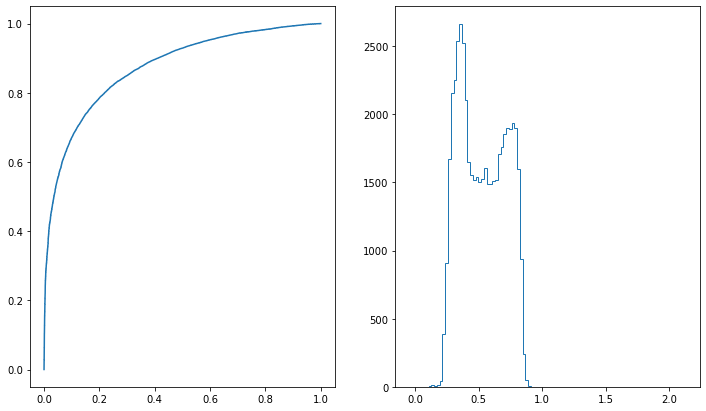

In [11]:
loader = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
plot_roc(loader)

In [12]:
loader = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
prediction_list, target_list = [], []
for batch in loader:
    inputs, targets = batch
    predictions, targets, out = test_step(inputs, targets)
    loss           += out

    prediction_list.append(predictions)
    target_list.append(targets)

y_reco  = tf.concat(prediction_list, axis = 0)
y_true  = tf.concat(target_list, axis = 0)
y_true  = tf.cast(y_true, tf.float32)

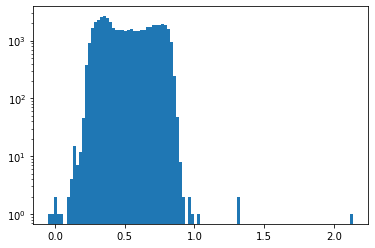

In [13]:
plt.hist(y_reco.numpy(), bins=100);
plt.yscale('log')

In [ ]:
k=1
# mask=np.abs(y_reco[:,k]-y_true[:,k])>np.pi
# mask=y_reco[:,k]<0

plt.hist(y_reco[:,k]%(np.pi/2), bins=50, alpha=0.4);
# plt.hist(np.abs(y_reco[:,2])-y_true[:,2], bins=50, alpha=0.4);
# plt.hist(np.abs(y_reco[:,k]), bins=50, alpha=0.4);
plt.hist(np.abs(y_true[:,k]), bins=50, alpha=0.4);

In [ ]:
fig3, ax3 = plt.subplots()
ax3.hist2d(y_true[:,k], y_reco[:,k]%(np.pi/2), bins=100, range=[np.percentile(y_reco[:,k]%(np.pi/2),[1,99]),[0,2]]);

In [ ]:
def test(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        inputs[0][:, :3] = inputs[0][:, :3] / 1000
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()


#     # Unit vects to angles
#     reco_vects = normalize(y_reco[:, 1:])    
#     true_vects = normalize(y_true[:, 1:])


#     reco_azi   = np.arctan2(reco_vects[:, 1], reco_vects[:, 0])
#     reco_zen   = np.arctan2(reco_vects[:, 2], np.sqrt((reco_vects[:, :2] ** 2).sum(1)))

#     true_azi   = np.arctan2(true_vects[:, 1], true_vects[:, 0])
#     true_zen   = np.arctan2(true_vects[:, 2], np.sqrt((true_vects[:, :2] ** 2).sum(1)))





    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []

    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_true[idx, :], y_reco[idx, :])

        w_energies.append(w)
        u_angles.append(u_angle)


    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (12, 12))

    for a in ax[0]:
        a_ = a.twinx()
        a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
        a_.set_yscale("log")
        a.set_xlabel("Log Energy")
    
    ax_top = ax[0]

    # Energy reconstruction
    ax_top[0].scatter(xs, w_energies)
    ax_top[0].set_title("Energy Performance")
    ax_top[0].set_ylabel(r"$w(\Delta log(E)$")


    # Angle reconstruction
    ax_top[1].scatter(xs, u_angles)
    ax_top[1].set_title("Angle Performance")
    ax_top[1].set_ylabel(r"$u(\Delta \Omega)$")


    # truth - pred plots
    ax_mid = ax[1]

    # Energy
    ax_mid[0].set_title("Energy")
    ax_mid[0].plot(y_true[:, 0], y_reco[:, 0], 'b.', alpha = 0.25)


    # Zenith
    ax_mid[1].set_title("Zenith angle")
    ax_mid[1].plot(true_zen, reco_zen, 'b.', alpha = 0.25)
    

    # Azimuthal
    ax_mid[2].set_title("Azimuthal angle")
    ax_mid[2].plot(true_azi, reco_azi, 'b.', alpha = 0.25)





    # Histogram of guesses
    ax_bot = ax[2]

    # Energy
    ax_bot[0].set_title("Energy")
    ax_bot[0].hist(y_reco[:, 0] - y_true[:, 0], label = "reco - true", histtype = "step", bins = 50)
    ax_bot[0].hist(y_reco[:, 0], label = "reco", histtype = "step", bins = 50)
    ax_bot[0].hist(y_true[:, 0], label = "true", histtype = "step", bins = 50)

    # Zenith
    ax_bot[1].set_title("Zenith angle")
    ax_bot[1].hist(reco_zen - true_zen, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[1].hist(reco_zen, label = "reco", histtype = "step", bins = 50)
    ax_bot[1].hist(true_zen, label = "true", histtype = "step", bins = 50)

    # Azimuthal
    ax_bot[2].set_title("Azimuthal angle")
    ax_bot[2].hist(reco_azi - true_azi, label = "reco - true", histtype = "step", bins = 50)
    ax_bot[2].hist(reco_azi, label = "reco", histtype = "step", bins = 50)
    ax_bot[2].hist(true_azi, label = "true", histtype = "step", bins = 50)
    ax_bot[2].legend()

    fig.tight_layout()

    return fig, ax

In [ ]:
test(loader_test)